## Isolation forest

### Importing Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


### Loading the dataset

In [11]:
df = pd.read_csv('../SavedData/dataset2_cleaned.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
#df.set_index('Datetime', inplace=True)

# Assuming we're focusing on total 'Amount' over time, for simplicity
#df_daily = df.resample('D').sum()['Amount']

In [47]:

training_transactions, testing_transactions = train_test_split(df, test_size=0.2, random_state=2)

# Displaying the shapes to verify the split
training_transactions.shape, testing_transactions.shape

training_payments_df = training_transactions[training_transactions['Amount'] > 0]
training_expenditures_df = training_transactions[training_transactions['Amount'] < 0]
training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()

testing_payments_df = testing_transactions[testing_transactions['Amount'] > 0]
testing_expenditures_df = testing_transactions[testing_transactions['Amount'] < 0]
testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()


/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/730436024.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/730436024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()


In [48]:
training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour
training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
training_expenditures_df['MonthOfYear'] = training_expenditures_df['Datetime'].dt.month

testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour
testing_expenditures_df['DayOfWeek'] = testing_expenditures_df['Datetime'].dt.dayofweek
testing_expenditures_df['DayOfMonth'] = testing_expenditures_df['Datetime'].dt.day
testing_expenditures_df['MonthOfYear'] = testing_expenditures_df['Datetime'].dt.month

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/2512906182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/2512906182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/2512906182.py:3: Sett

In [49]:
patterns_train = training_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear'])['Amount'].sum().reset_index()
patterns_test = testing_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear'])['Amount'].sum().reset_index()

In [50]:
patterns_train

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Amount
0,101531259.0,0,0,1,5,859.00
1,101531259.0,0,1,1,8,859.00
2,101531259.0,0,2,1,3,859.00
3,101531259.0,0,2,1,11,859.00
4,101531259.0,0,3,1,6,859.00
...,...,...,...,...,...,...
139479,999752672.0,23,4,30,6,15.99
139480,999752672.0,23,4,31,3,15.99
139481,999752672.0,23,5,29,4,680.00
139482,999752672.0,23,5,30,9,15.99


In [57]:
# Calculating median transaction amount for each user for each day of the month
median_day_of_month = patterns_train.groupby(['Account No', 'DayOfMonth'])['Amount'].median().reset_index()

median_amounts_pivot = median_day_of_month.pivot_table(index='Account No', columns='DayOfMonth', values='Amount', aggfunc=np.median)

# Reset index to make 'Account No' a column again
median_amounts_pivot.reset_index(inplace=True)

# Rename columns to have a proper name
median_amounts_pivot.columns.name = None
median_amounts_pivot.columns = ['Account No'] + [f'Day_{i}' for i in range(1, 32)]

# Fill NaN values with zeros if needed, or leave as NaN if you prefer
# median_amounts_pivot.fillna(0, inplace=True)

median_amounts_pivot

,Account No,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,...,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
0,101531259.0,859.00,104.84,65.380,83.910,87.50,25.980,51.97,150.50,45.410,...,100.650,114.210,NaN,NaN,NaN,149.090,66.725,88.660,92.995,61.230
1,104832000.0,861.00,106.27,38.825,NaN,84.57,45.645,59.98,54.19,70.105,...,45.910,65.700,NaN,7.310,33.145,49.850,129.970,25.485,407.485,770.000
2,105375973.0,158.10,NaN,64.990,140.690,146.96,NaN,20.94,80.22,NaN,...,NaN,39.260,66.500,NaN,25.970,143.260,34.980,NaN,39.020,48.030
3,106601471.0,21.98,35.75,18.885,34.415,20.73,72.220,3.23,NaN,15.190,...,33.465,37.625,26.790,36.815,48.890,23.620,24.070,19.375,40.255,30.985
4,108481285.0,44.47,18.98,9.990,34.795,20.97,16.550,34.00,25.28,15.780,...,31.490,23.960,28.610,27.640,12.530,44.920,29.760,12.500,28.220,26.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,995615876.0,637.00,90.07,74.990,NaN,33.64,54.990,33.09,223.43,146.725,...,50.970,119.980,134.990,12.990,36.745,57.090,73.760,20.490,26.980,29.975
972,996042490.0,501.00,25.00,75.920,30.740,48.85,62.330,34.49,NaN,15.980,...,71.360,25.000,93.470,5.970,12.980,68.550,34.980,1500.000,824.985,46.990
973,998390769.0,1013.00,111.75,169.500,147.595,96.50,69.970,50.34,5.99,42.180,...,129.970,126.500,87.140,214.860,NaN,165.575,126.870,118.380,55.460,33.975
974,998405607.0,143.97,64.62,NaN,55.630,35.00,NaN,51.19,93.52,69.395,...,42.210,124.640,NaN,129.440,NaN,93.550,110.190,55.560,151.965,55.960


In [51]:
X_train = median_day_of_month[['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
X_test = patterns_test[['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]

# Normalize/Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = IsolationForest(n_estimators=100, contamination=0.05)
model.fit(X_train_scaled)

# Predict anomalies
test_preds = model.predict(X_test_scaled)
patterns_test['anomaly'] = test_preds

# Flag anomalies
anomalies = patterns_test[patterns_test['anomaly'] == -1]

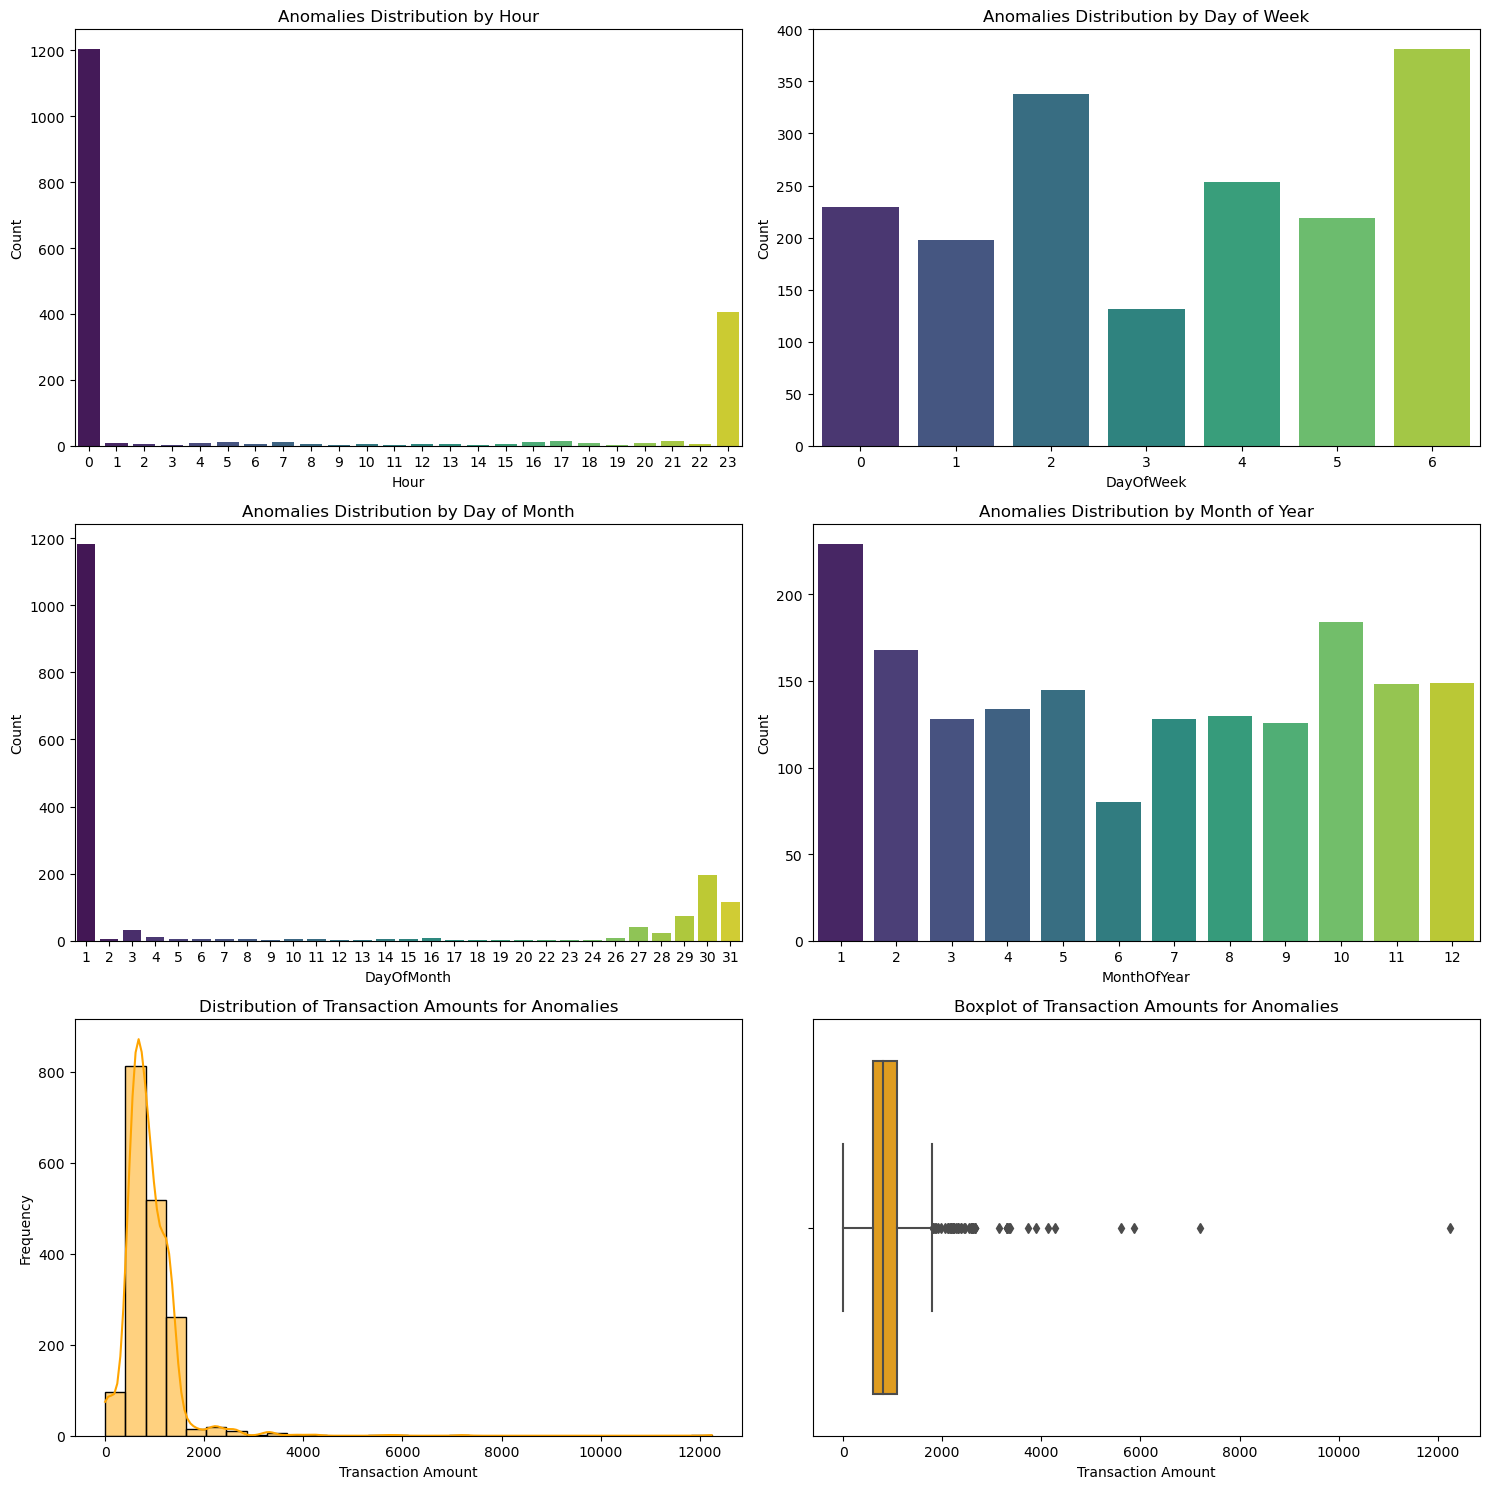

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


# Visualize the distribution of anomalies across different features

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Hour
sns.countplot(x='Hour', data=anomalies, ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title('Anomalies Distribution by Hour')
axs[0, 0].set_ylabel('Count')

# Day of Week
sns.countplot(x='DayOfWeek', data=anomalies, ax=axs[0, 1], palette='viridis')
axs[0, 1].set_title('Anomalies Distribution by Day of Week')
axs[0, 1].set_ylabel('Count')

# Day of Month
sns.countplot(x='DayOfMonth', data=anomalies, ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Anomalies Distribution by Day of Month')
axs[1, 0].set_ylabel('Count')

# Month of Year
sns.countplot(x='MonthOfYear', data=anomalies, ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Anomalies Distribution by Month of Year')
axs[1, 1].set_ylabel('Count')

# Transaction Amount - Distribution
sns.histplot(anomalies['Amount'], kde=True, bins=30, ax=axs[2, 0], color='orange')
axs[2, 0].set_title('Distribution of Transaction Amounts for Anomalies')
axs[2, 0].set_xlabel('Transaction Amount')
axs[2, 0].set_ylabel('Frequency')

# Transaction Amount - Boxplot to identify outliers in amounts
sns.boxplot(x='Amount', data=anomalies, ax=axs[2, 1], color='orange')
axs[2, 1].set_title('Boxplot of Transaction Amounts for Anomalies')
axs[2, 1].set_xlabel('Transaction Amount')

plt.tight_layout()
plt.show()


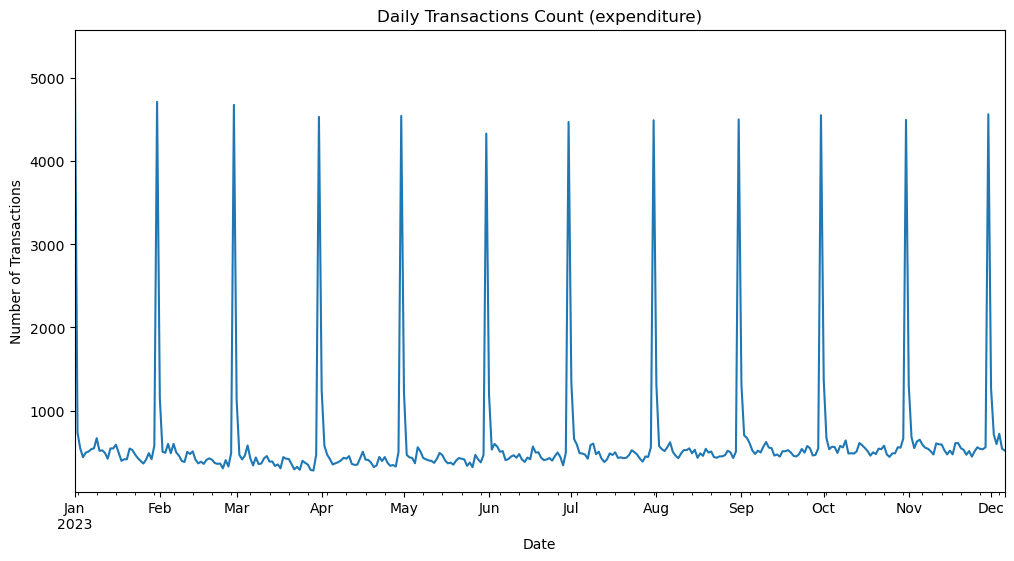

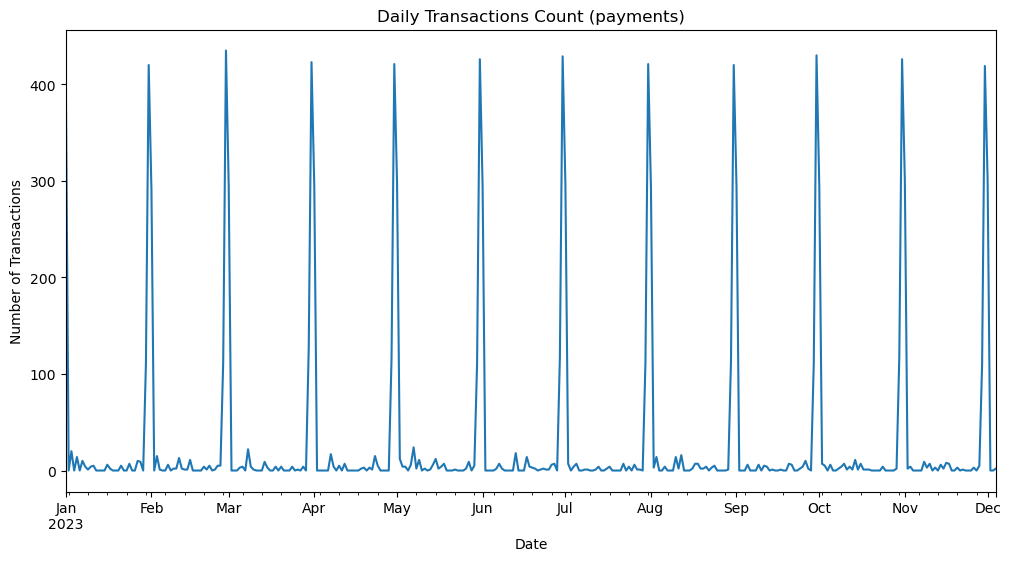

In [4]:
# Sum of all daily transactions
daily_transactions = expenditures_df.resample('D').size()

# Plot
plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Daily Transactions Count (expenditure)')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()

# Sum of all daily transactions
daily_transactions = payments_df.resample('D').size()

# Plot
plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Daily Transactions Count (payments)')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()

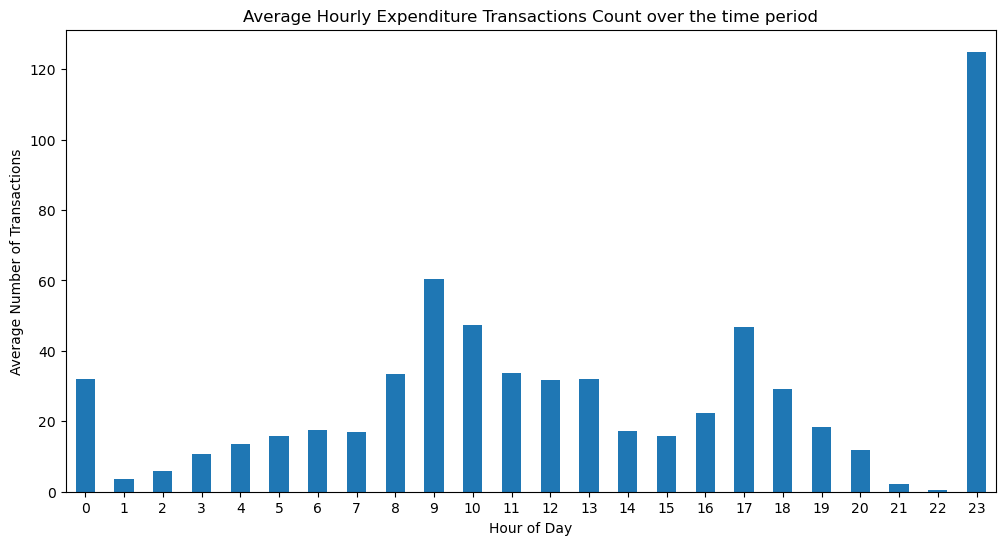

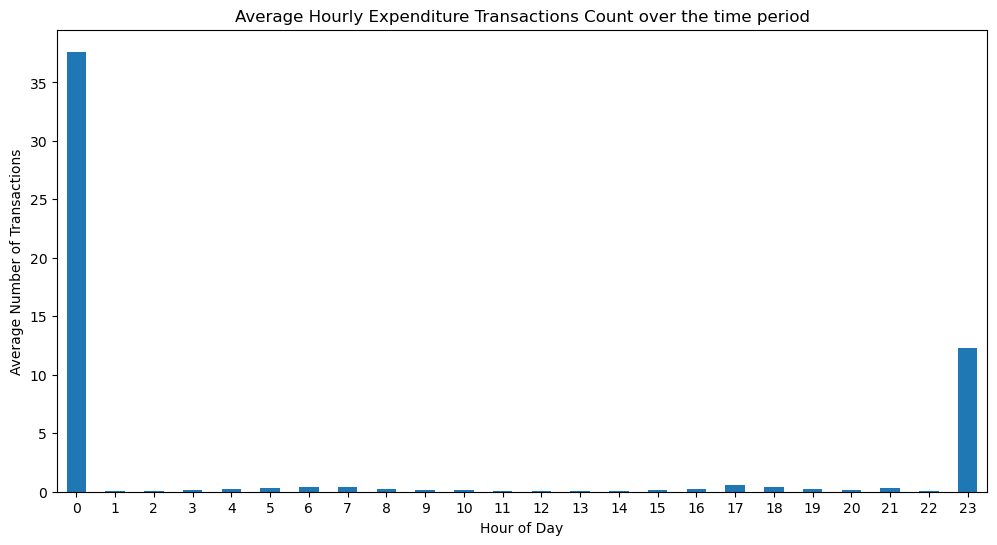

In [5]:
# Calculate the number of unique dates (days) in the DataFrame
unique_days = pd.Series(expenditures_df.index.date).nunique()

# Group by hour and count transactions, then divide by the number of unique days
hourly_transactions = expenditures_df.groupby(expenditures_df.index.hour).size() / unique_days

# Plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Expenditure Transactions Count over the time period')
plt.ylabel('Average Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.show()

# Calculate the number of unique dates (days) in the DataFrame
unique_days = pd.Series(payments_df.index.date).nunique()

# Group by hour and count transactions, then divide by the number of unique days
hourly_transactions = payments_df.groupby(payments_df.index.hour).size() / unique_days

# Plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Expenditure Transactions Count over the time period')
plt.ylabel('Average Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.show()



/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_74257/2188435756.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_amount_spent = expenditures_df.resample('W').sum()['Amount']


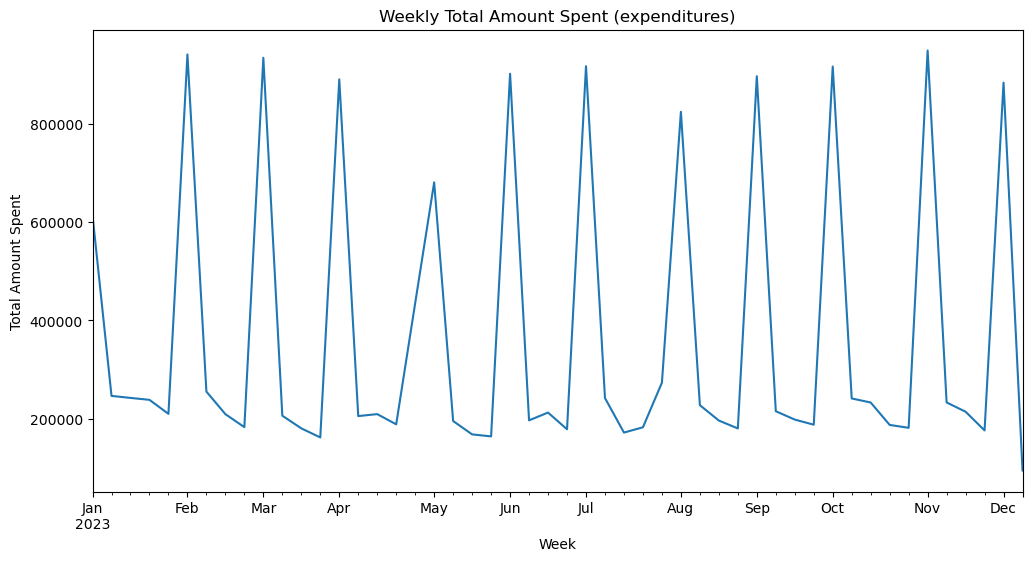

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_74257/2188435756.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_amount_spent = payments_df.resample('W').sum()['Amount']


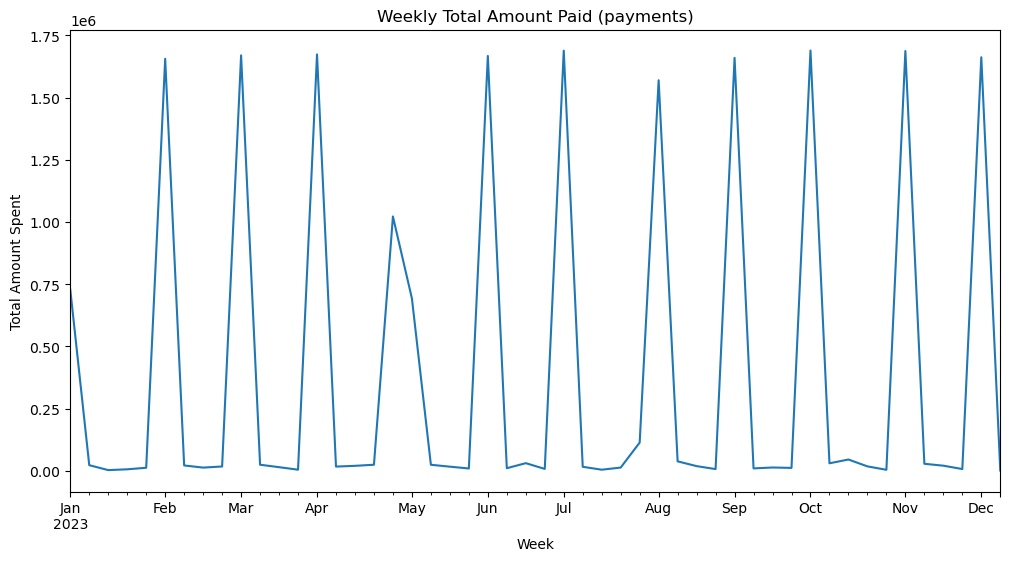

In [6]:
# Sum of amount spent each week
weekly_amount_spent = expenditures_df.resample('W').sum()['Amount']

# Plot
plt.figure(figsize=(12, 6))
weekly_amount_spent.plot(title='Weekly Total Amount Spent (expenditures)')
plt.ylabel('Total Amount Spent')
plt.xlabel('Week')
plt.show()

# Sum of amount spent each week
weekly_amount_spent = payments_df.resample('W').sum()['Amount']

# Plot
plt.figure(figsize=(12, 6))
weekly_amount_spent.plot(title='Weekly Total Amount Paid (payments)')
plt.ylabel('Total Amount Spent')
plt.xlabel('Week')
plt.show()


## Isolation forest anomaly detection model

In [7]:
# Drop non-numeric columns explicitly
# Assuming 'Date', 'Timestamp', and 'Third Party Name' are non-numeric
expenditures_df_numeric = expenditures_df.drop(['Date', 'Timestamp', 'Third Party Name', 'Third Party Account No'], axis=1)

# Optionally, convert 'Date' and 'Timestamp' to datetime and extract useful features
expenditures_df['Datetime'] = pd.to_datetime(expenditures_df['Date'] + ' ' + expenditures_df['Timestamp'])
expenditures_df_numeric['DayOfWeek'] = expenditures_df['Datetime'].dt.dayofweek
expenditures_df_numeric['HourOfDay'] = expenditures_df['Datetime'].dt.hour
expenditures_df_numeric['DayOfMonth'] = expenditures_df.index.day



/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_74257/1290006811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_df['Datetime'] = pd.to_datetime(expenditures_df['Date'] + ' ' + expenditures_df['Timestamp'])


In [9]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination= 0.02)
model.fit(expenditures_df_numeric)

# Predict anomalies (-1 for anomalies, 1 for normal)
expenditures_df['anomaly'] = model.predict(expenditures_df_numeric)


/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_74257/2544299843.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_df['anomaly'] = model.predict(expenditures_df_numeric)


In [10]:
# Filtering anomalies
anomalies = expenditures_df[expenditures_df['anomaly'] == -1]

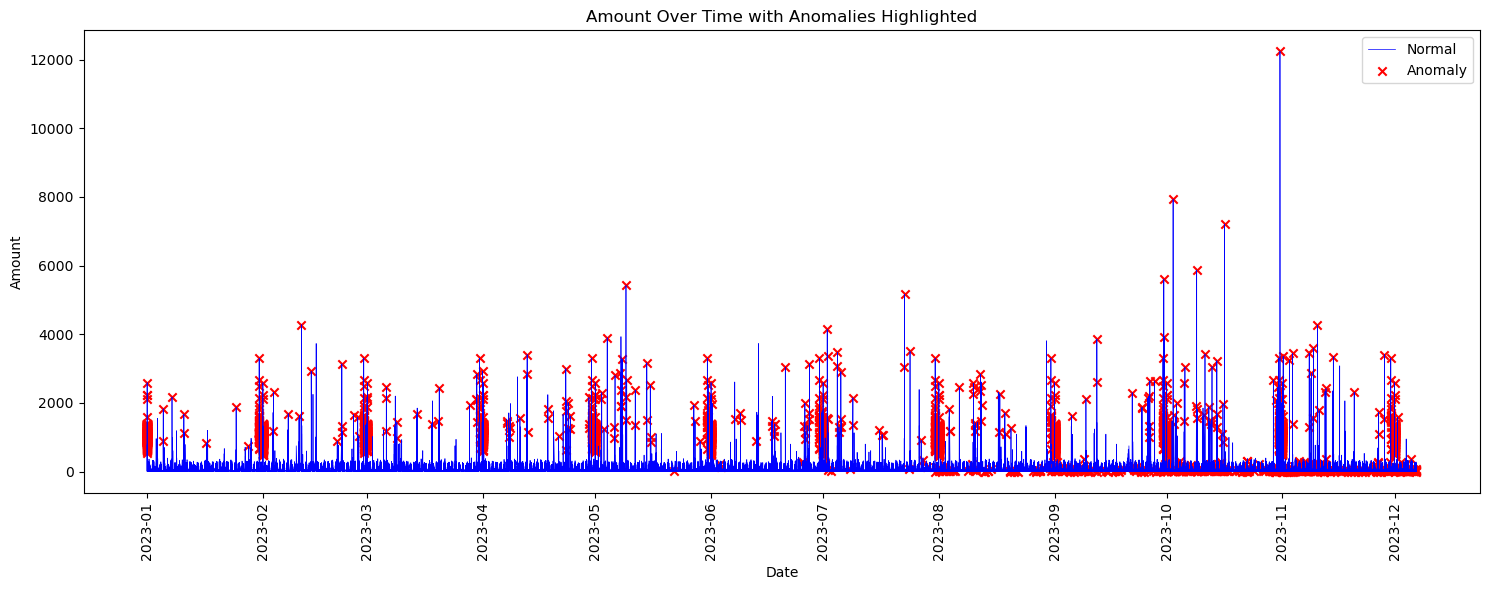

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'Amount' is the column of interest
plt.figure(figsize=(15, 6))

# Plotting normal data
plt.plot(expenditures_df.index, expenditures_df['Amount'], label='Normal', color='blue', linestyle='-', linewidth=0.5)

# Highlighting anomalies
anomalies = expenditures_df[expenditures_df['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['Amount'], color='red', label='Anomaly', marker='x')

# Improving readability
plt.title('Amount Over Time with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.legend()

plt.show()


In [ ]:
# Assuming expenditures_df is already prepared and the 'anomaly' column is populated
# This line is correct; it computes the number of anomalies for each hour of the day
anomalies_by_hour = expenditures_df[expenditures_df['anomaly'] == -1]['hour_of_day'].value_counts()

# Now we'll fix the plotting code:
plt.figure(figsize=(15, 5))
anomalies_by_hour.sort_index().plot(kind='bar', title='Anomalies by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalies')
plt.xticks(ticks=range(24), labels=[str(hour) for hour in range(24)], rotation=0)
plt.show()



In [ ]:
# Count daily transactions for each customer
daily_transactions_per_customer = expenditures_df.groupby(['Account No']).resample('D').size().unstack(fill_value=0)

In [ ]:
# Initialize the anomaly detector
quantile_ad = QuantileAD(high=0.95, low=0.05)  # Adjust based on your requirement

# Prepare to store anomaly detection results
anomalies_results = {}

# Iterate over a subset of customers (e.g., first 10 for demonstration)
for customer in daily_transactions_per_customer.index[:10]:
    # Extract the series for the current customer
    series = daily_transactions_per_customer.loc[customer]
    
    # Convert series to have a DatetimeIndex if it's not already in that format
    series = pd.Series(data=series.values, index=pd.to_datetime(daily_transactions_per_customer.columns))
    
    # Validate the series format for ADTK
    validated_series = validate_series(series)
    
    # Detect anomalies
    anomalies = quantile_ad.fit_detect(validated_series)
    
    # Store or process the anomalies found for each customer
    anomalies_results[customer] = anomalies

    # Plotting using matplotlib for customization
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.plot(validated_series.index, validated_series, label='Daily Transactions')
    
    # Highlight anomalies
    if anomalies is not None and anomalies.any():
        ax.scatter(validated_series.index[anomalies], validated_series[anomalies], color='red', label='Anomaly')

    ax.set_title(f"Customer {customer}")
    ax.legend()
    plt.show()

